In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import time
from patsy import dmatrix
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import KFold

## Part 1

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


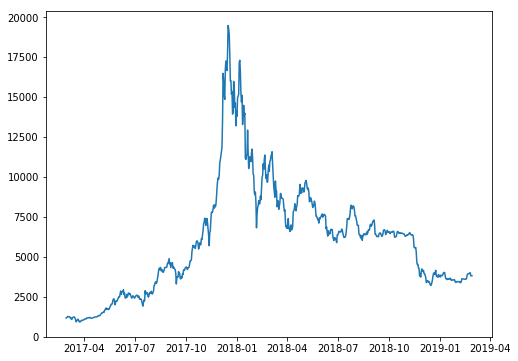

In [5]:
data = pd.read_csv('BitCoin.csv', names=["date", "price"])
data['date'] = data['date'].apply(lambda x : str(x)[:10])
data['date'] = pd.to_datetime(data['date'])
date =data['date']
date_int = data['date'].apply(lambda x: int(time.mktime(x.timetuple())))
price = data['price']

#Display first graph
plt.figure(1, figsize=(8,6))
plt.plot(data['date'],price, label="Original Plot")


## Non-parametric regression (B-spline)

R Square score of B-spline regression model: 0.9890747845711219


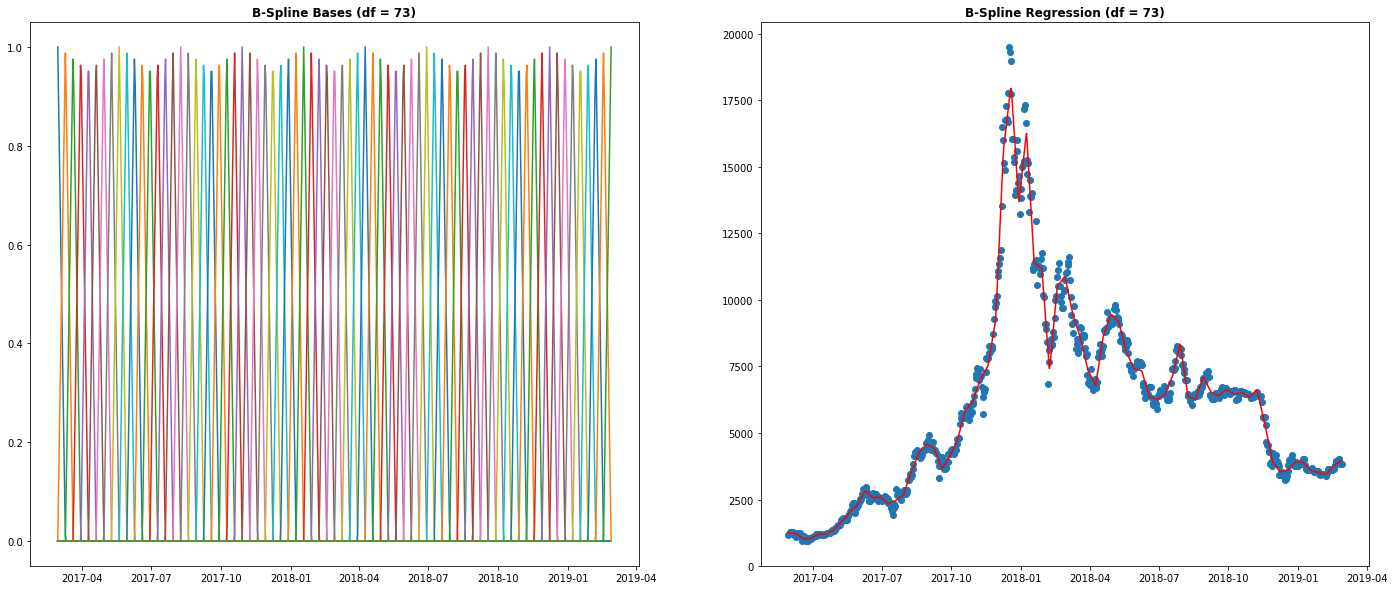

In [6]:
xphi = dmatrix("bs(date_int, df=73, degree=1, include_intercept=True) - 1", {"date_int": date_int})
linreg = LinearRegression()
linreg.fit(xphi, price)
yfit = linreg.predict(xphi)
print("R Square score of B-spline regression model:",linreg.score(xphi,price))

fig, axs = plt.subplots(1, 2, figsize=(24, 10))
axs[0].plot(date, xphi)
axs[0].set_title('B-Spline Bases (df = 73)', fontweight="bold")
axs[1].plot(date, price, 'o')
axs[1].plot(date, yfit, color="red")
axs[1].set_title('B-Spline Regression (df = 73)', fontweight="bold")
plt.show()


## Lasso regularisation 

### Solution paths 

Text(0.5, 1.0, 'Mean squared error depending on penalty')

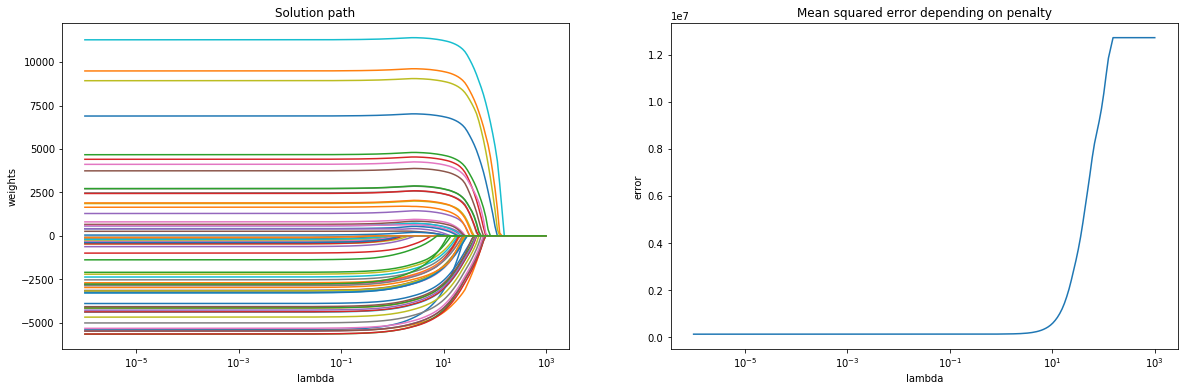

In [7]:
alphas = np.logspace(-6, 3, 200)
coefs = []
error = []
for a in alphas:
    lasso = linear_model.Lasso(alpha=a, tol=0.1)
    lasso.fit(xphi, price)
    coefs.append(lasso.coef_)
    error.append(mean_squared_error(price, lasso.predict(xphi)))

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,6))
ax[0].plot(alphas, coefs)
ax[0].set_xscale('log')
ax[0].set_xlabel('lambda')
ax[0].set_ylabel('weights')
ax[0].set_title('Solution path')
ax[1].plot(alphas, error)
ax[1].set_xscale('log')
ax[1].set_xlabel('lambda')
ax[1].set_ylabel('error')
ax[1].set_title('Mean squared error depending on penalty')

### These series of graph show the effect of increasing the regularisation parameter. 

R Square score of lasso model when parameter is :1    0.988650933141916


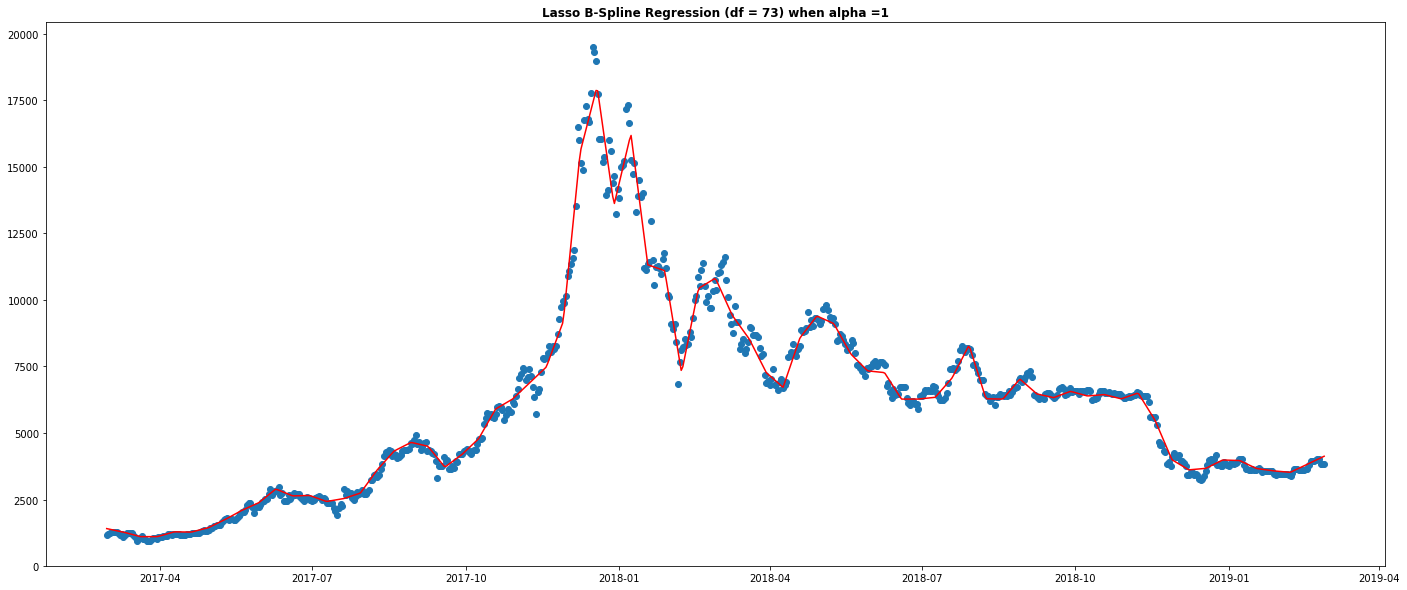

R Square score of lasso model when parameter is :30    0.7307093632983731


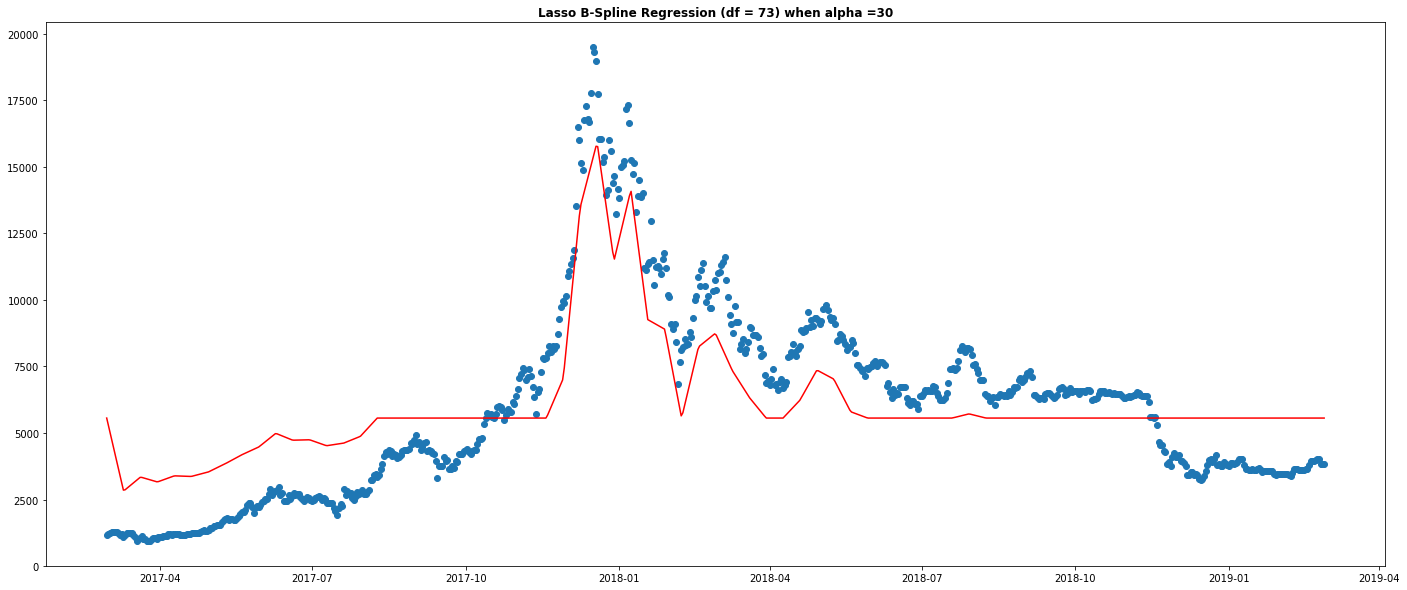

R Square score of lasso model when parameter is :60    0.40023109522568245


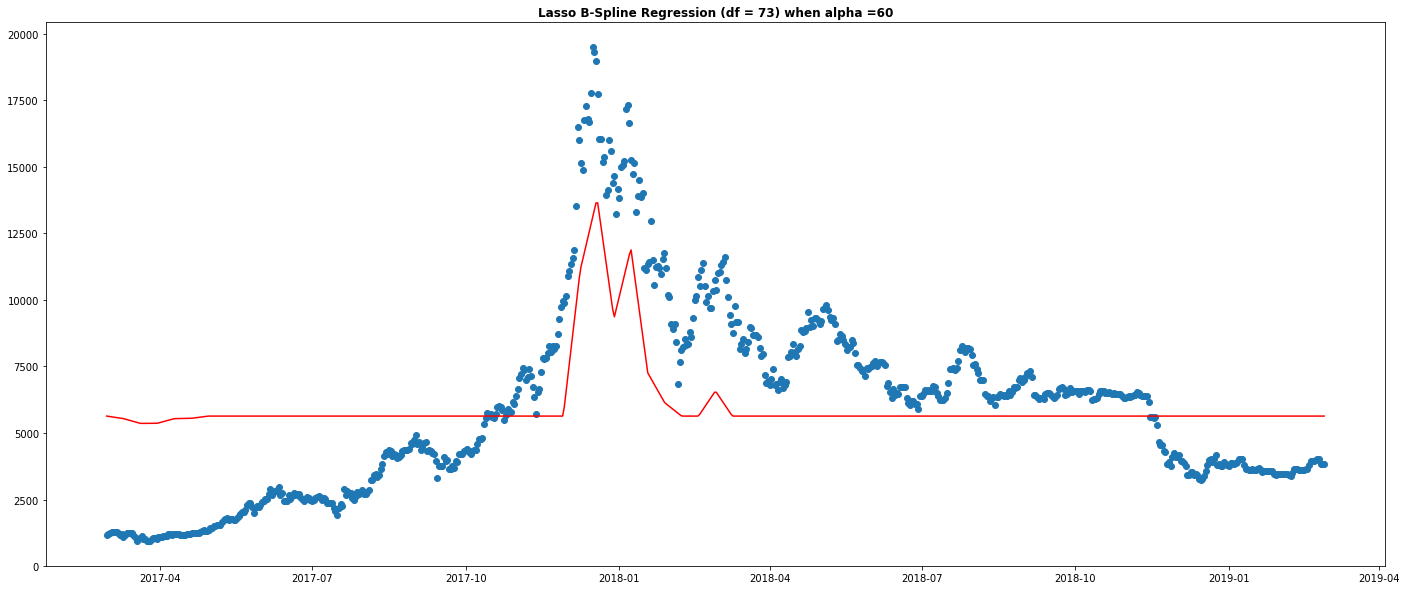

R Square score of lasso model when parameter is :100    0.19179138705332666


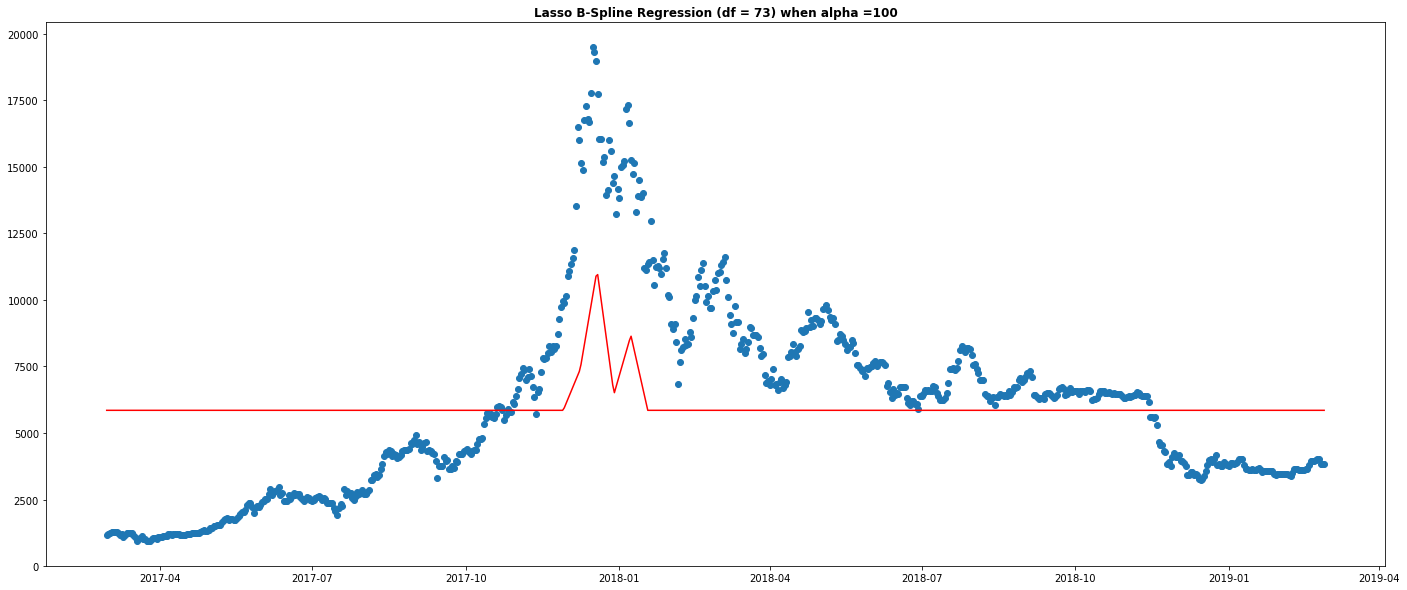

R Square score of lasso model when parameter is :1000    0.0


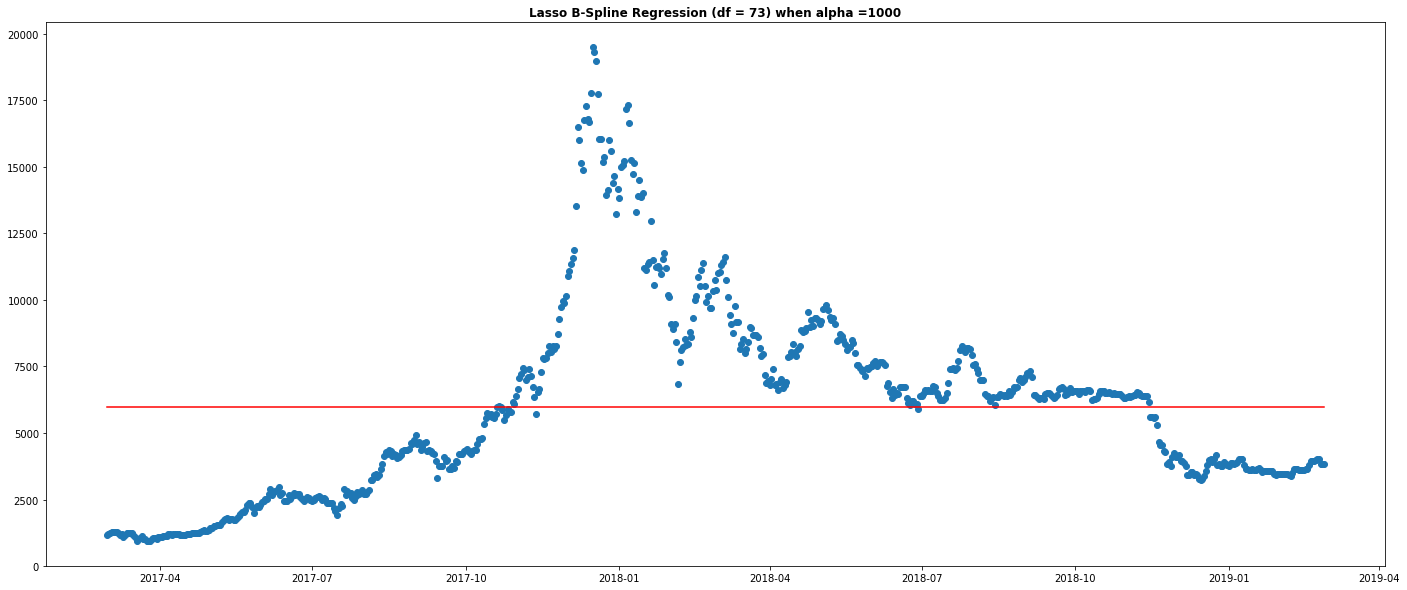

In [8]:

#changing value of alpha
for a in [1,30, 60, 100, 1000]:
  lasso = linear_model.Lasso(alpha=a)
  lasso.fit(xphi, price)
  yfit = lasso.predict(xphi)
  print("R Square score of lasso model when parameter is :"+str(a),"  ",lasso.score(xphi,price))

  plt.figure(2, figsize=(24, 10))
  plt.plot(date, price, 'o')
  plt.plot(date, yfit, color="red")
  plt.title('Lasso B-Spline Regression (df = 73) when alpha ='+str(a), fontweight="bold")
  plt.show()


## Step 3

By making use of the solution path, we can determine the 30 most important baes are the coefficients which become non-zero when the regularisation parameter decreases from a large value. 

This is not an effective method of doing so because the 30 most important bases are  centered around the middle. Therefore the values in the side are inaccurately predicted.

List of 30 most important basis [25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 50, 51, 54, 55, 57, 58, 59, 61]
Value of resularization parameter when there are 30 non-zero coefficients : 3.2550885998350565
R2 score of model :  0.8716098799087013


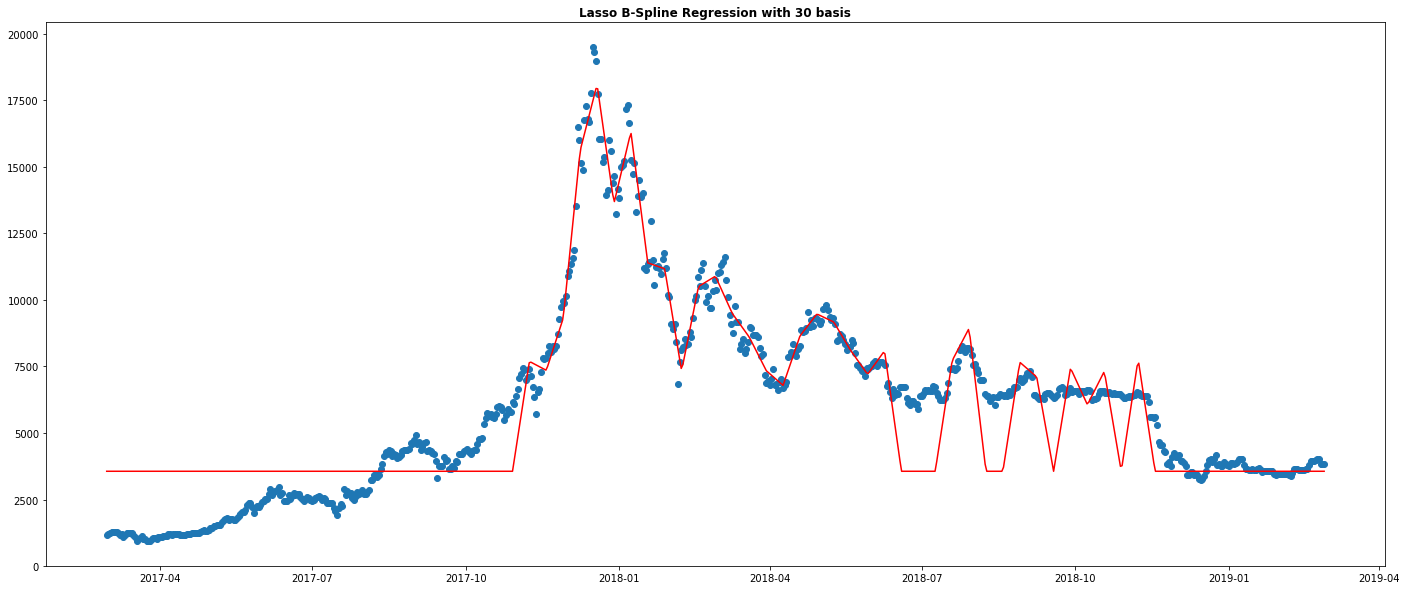

In [9]:
def nonzero(l,ll):
  out = []
  for i,coef in enumerate(l):
    if coef > 0:
      try:
        ll.index(i)
      except:
        out.append(i)
  return out

alphas = np.logspace(3, -6, 200)
coefs = []
for a in alphas:
    lasso = linear_model.Lasso(alpha=a)
    lasso.fit(xphi, price)
    coefs = coefs + nonzero(lasso.coef_, coefs)
    if len(coefs) > 29:
      coefs.sort()
      print("List of 30 most important basis",coefs)
      print("Value of resularization parameter when there are 30 non-zero coefficients :",a)
      break
xphi_df = pd.DataFrame(xphi)
xphi_df = xphi_df.iloc[:,coefs]

linreg = LinearRegression()
linreg.fit(xphi_df, price)
yfit = linreg.predict(xphi_df)
print("R2 score of model : ",linreg.score(xphi_df,price))
plt.figure(2, figsize=(24, 10))
plt.plot(date, price, 'o')
plt.plot(date, yfit, color="red")
plt.title('Lasso B-Spline Regression with 30 basis', fontweight="bold")
plt.show()


### Since we are not using all the basis from B-spline which are sparse, our predicted model is not accurate at certain regions. The basis which express 2017-07 ~ 2017-10 have parameter to be equal to zero.

### Yet, we can still say that the regions of predicted intervals are more volatile. This is because of the fitting optimizes to maximize R2 score/ minimize mean square error.

## Step 4


R Square score of lasso model when regularized parameter is 0.14314589375234785 0.9890667927169328
Cross validation score is -10.968121880999808


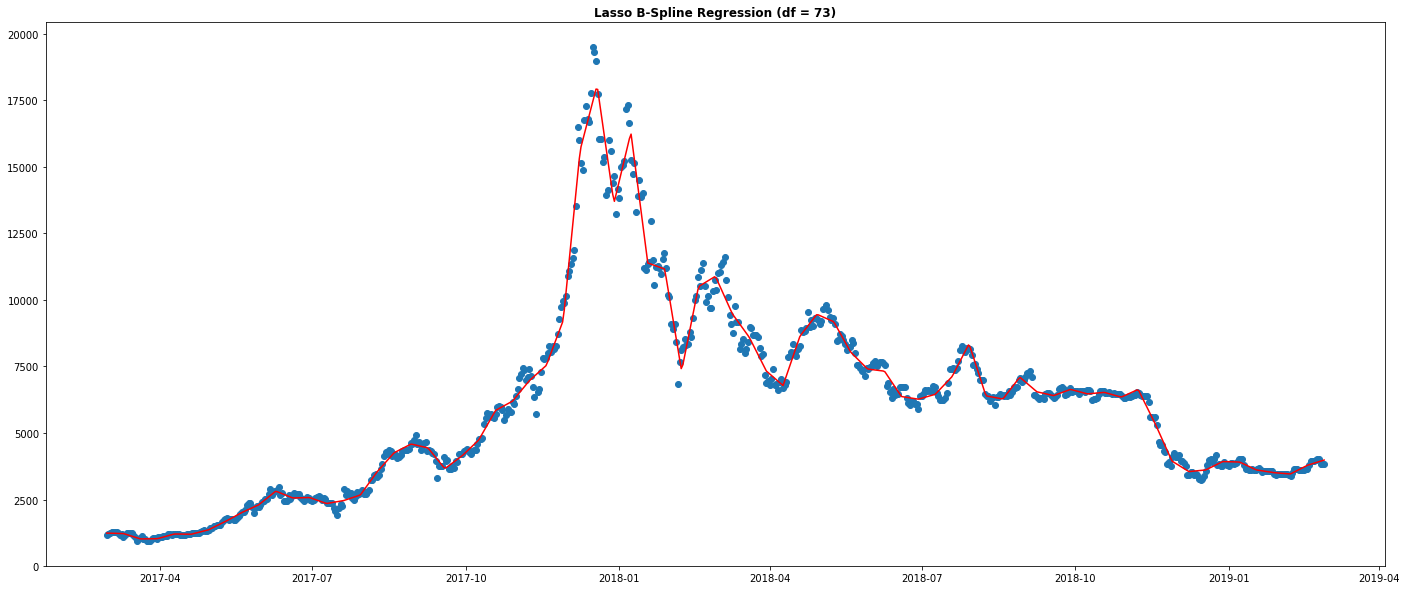

In [10]:
alphas = np.logspace(3, -6, 200)

savealpha = 0
bestscore = -1000
for alpha in alphas:
  lasso = Lasso(alpha=alpha, tol = 0.01)
  lasso.fit(xphi, price)
  yfit = lasso.predict(xphi)
  if  bestscore < cross_val_score(lasso, xphi,price, cv=KFold(5) ,scoring='r2').mean():
    bestscore = cross_val_score(lasso, xphi,price, cv=KFold(5) ,scoring='r2').mean()
    savemodel = lasso
    savealpha = alpha

print("R Square score of lasso model when regularized parameter is",savealpha, savemodel.score(xphi,price))
print("Cross validation score is", bestscore)
yfit = savemodel.predict(xphi)
plt.figure(2, figsize=(24, 10))
plt.plot(date, price, 'o')
plt.plot(date, yfit, color="red")
plt.title('Lasso B-Spline Regression with CV', fontweight="bold")
plt.show()

 


### Even though the cross validation metric was R2, we can notice that the cross validation score is very low. In fact it is performing worse than just taking the mean value of price. This happens because in the process of cross-validation they split the X into 5 folds randomly. Therefore there will be 20 % missing rows of X which represent the B-spline basis. A model that is fitted by such a X will obviously have low R2 scores because the basis is not complete.
